# Proyecto de series de tiempo univariadas (Red Neuronal Recurrente)
El siguiente Script abarca la modelación de la tasa de desempleo en Colombia; desde enero de 2001 hasta diciembre de 2023; utilizando redes neuronales recurrentes.

## Integrantes: Anderson Guarín, Ander Cristancho, Juan Duitama
## Librerías utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

## Importación datos

In [2]:
import os
#Directorio mío
os.chdir("D:\Estadística\Semestres\Semestre 9\Series de Tiempo Univariadas\Datos")
#Directorio Ander
#os.chdir(r"C:\Users\EQUIPO\OneDrive\Documentos\Documentos Ander\UNAL\Series de tiempo\Mis series y descriptiva")
os.getcwd()

'D:\\Estadística\\Semestres\\Semestre 9\\Series de Tiempo Univariadas\\Datos'

In [3]:
Data = pd.read_excel("Desempleo.xlsx",skiprows=5,nrows=277)
Data = Data.iloc[:,[0,2]]
print(Data.dtypes)
# Cambiar los nombres de las columnas
nuevos_nombres = ['AnioMes', 'TasaDesempleo']
Data.columns = nuevos_nombres
Data

Año-Mes (AAAA-MM)         object
Tasa de desempleo (%)    float64
dtype: object


AnioMes  TasaDesempleo
0    2023-12      10.013717
1    2023-11       9.007386
2    2023-10       9.230912
3    2023-09       9.252674
4    2023-08       9.277372
..       ...            ...
271  2001-05      14.035800
272  2001-04      14.515100
273  2001-03      15.811900
274  2001-02      17.434200
275  2001-01      16.622300

[276 rows x 2 columns]

In [4]:
#Primera observación de los datos
Data['AnioMes']=pd.to_datetime(Data['AnioMes'])#Convirtiendo la columna año y mes a formato fecha
Desempleo=Data.set_index('AnioMes')#Ordenando el dataframe, pero creo uno nuevo para volverlo objeto de series de tiempo luego
Desempleo = Desempleo.iloc[::-1]
Desempleo

TasaDesempleo
AnioMes                  
2001-01-01      16.622300
2001-02-01      17.434200
2001-03-01      15.811900
2001-04-01      14.515100
2001-05-01      14.035800
...                   ...
2023-08-01       9.277372
2023-09-01       9.252674
2023-10-01       9.230912
2023-11-01       9.007386
2023-12-01      10.013717

[276 rows x 1 columns]

El análisis descriptivo fue realizado en scripts previos, de los cuales se seleccionaron los retardos 2, 3, 4, 5, 6, 9, 10, 11 y 12 como features.

## Organización de los datos
Utilizaremos el 80% de los datos como entrenamiento y el 20% restante como prueba.

In [5]:
split = int(len(Data) * 0.8)
DataTrain = Desempleo.iloc[:split]
DataTest = Desempleo.iloc[split:]

n_steps = 12 #Utilizaremos los 12 retardos y posteriormente retiraremos el séptimo y octavo
n_steps_ahead = 1 #Predicción a un paso

Estandarización

In [6]:
mu = float(DataTrain.mean())
sigma = float(DataTrain.std())

stdize_input = lambda x: (x - mu) / sigma

DataTrain = DataTrain.apply(stdize_input)
DataTest = DataTest.apply(stdize_input)

C:\Users\JUAN DAVID\AppData\Local\Temp\ipykernel_24836\354287528.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(DataTrain.mean())
C:\Users\JUAN DAVID\AppData\Local\Temp\ipykernel_24836\354287528.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(DataTrain.std())


Creando los tensores con los retardos

In [7]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

Entrenamiento

In [8]:
x_train = get_lagged_features(DataTrain, n_steps, n_steps_ahead)
y_train =  DataTrain.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = DataTrain.index[n_steps + n_steps_ahead - 1:]

Recordemos que solo trabajaremos con los retardos 2, 3, 4, 5, 6, 9, 10, 11 y 12; por lo tanto removeremos los retardos 1, 7 y 8 de este tensor que cuenta con todos los 12

In [9]:
indices_to_remove = [0, 6, 7]
# Eliminar los elementos a lo largo de la segunda dimensión (eje 1)
x_train = np.delete(x_train, indices_to_remove, axis=1)

Prueba

In [10]:
x_test = get_lagged_features(DataTest, n_steps, n_steps_ahead)
y_test =  DataTest.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = DataTest.index[n_steps + n_steps_ahead - 1:]

In [11]:
x_test = np.delete(x_test, indices_to_remove, axis=1)

In [12]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(208, 9, 1), (208, 1), (44, 9, 1), (44, 1)]


## Creación de las redes neuronales
Tres redes neuronales recurrentes serán implementadas, una simple, una GRU (Gated Recurrent Unit) y una LSTM (Long Short-Term Memory).

In [13]:
def SimpleRNN_(n_units, l1_reg, seed=1729):
  #def SimpleRNN_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def GRU_(n_units, l1_reg, seed=1729):
  #def GRU_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def LSTM_(n_units, l1_reg, seed=1729):
  #def LSTM_(n_units = 10,  seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Definimos las épocas y mantenemos un batch de 12

In [14]:
max_epochs = 100 #Definimos 100 épocas
batch_size = 12# Mantenemos el tamaño del batch

In [15]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, min_delta=1e-7, restore_best_weights=True)
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [16]:
do_training = False

## Validación Cruzada

In [17]:
from scikeras.wrappers import KerasRegressor

In [18]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

## Entrenamiento del modelo

In [19]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

## Guardando el modelo entrenado

In [20]:
for key in params.keys():
    params[key]['model'].save('RNNs-Desempleo-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
    params[key]['model'].save('RNNs-Desempleo-SAVED-' + key + '.keras', overwrite=True)  # creates a HDF5 file

AttributeError: 'NoneType' object has no attribute 'save'

## Importando el modelo entrenado
Cuando vuelva a este script no hago el entrenamiento de nuevo sino simplemento cargo el modelo guardado

In [16]:
do_training = False
if do_training is False:
     for key in params.keys():
        params[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED-' + key + '.hdf5')

## Desempeño de los modelos

In [17]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)#Predicciones del conjunto de entrenamiento
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])#MSE en entrenamiento
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1)#Predicciones del conjunto de prueba
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])#MSE en prueba

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_61 (SimpleRNN)       │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43 (176.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_61 (GRU)                    │ (None, 20)             │         1,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403 (5.48 KB)

 Trainable params: 1,401 (5.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,783 (6.97 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


## Revisión de los MSE en los conjuntos de prueba

In [18]:
for key in params.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 2.970641783397666
El MSE de la red gru en el conjunto de prueba es 5.305906568978424
El MSE de la red lstm en el conjunto de prueba es 5.96381683289774


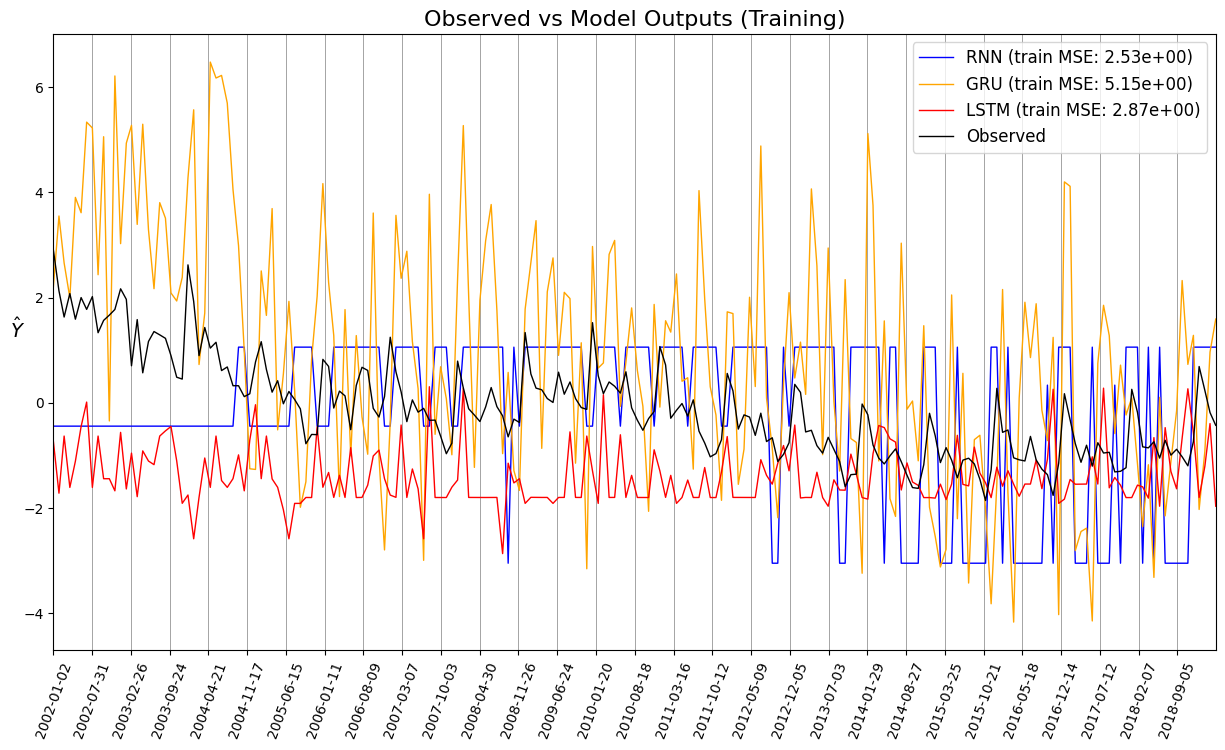

In [19]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

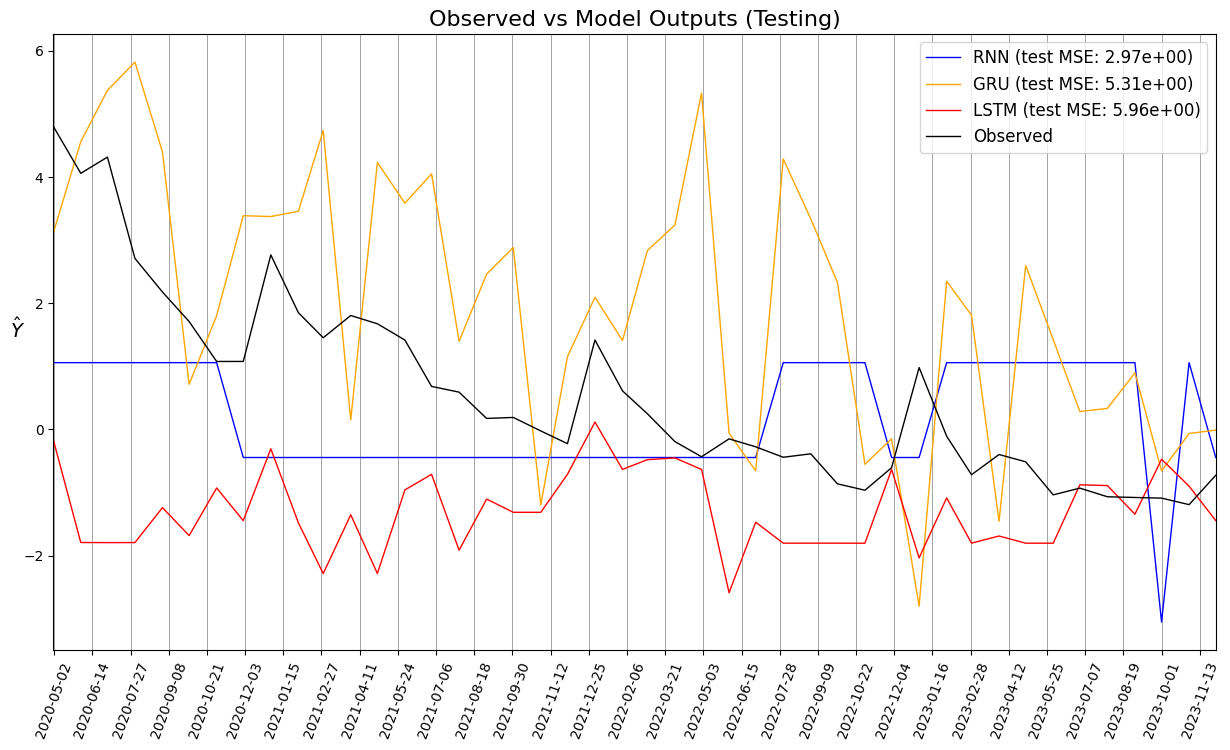

In [20]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

# Agregando estacionalidad para intentar mejorar pronósticos
Agregaremos una nueva covariable, el mes que se va a predecir

In [21]:
#Creamos las dummies de los meses
meses = ["Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre", "Enero"]
meses_repetidos = (meses * (276 // len(meses) + 1))[:276]
meses = pd.DataFrame({'MesSiguiente': meses_repetidos})
meses_dummies = pd.get_dummies(meses, columns=['MesSiguiente'])
meses_dummies

MesSiguiente_Abril  MesSiguiente_Agosto  MesSiguiente_Diciembre  \
0                 False                False                   False   
1                 False                False                   False   
2                  True                False                   False   
3                 False                False                   False   
4                 False                False                   False   
..                  ...                  ...                     ...   
271               False                False                   False   
272               False                False                   False   
273               False                False                   False   
274               False                False                    True   
275               False                False                   False   

     MesSiguiente_Enero  MesSiguiente_Febrero  MesSiguiente_Julio  \
0                 False                  True               False   
1                 False                 False               False   
2                 False                 False               False   
3                 False                 False               False   
4                 False                 False               False   
..                  ...                   ...                 ...   
271               False                 False               False   
272               False                 False               False   
273               False                 False               False   
274               False                 False               False   
275                True                 False               False   

     MesSiguiente_Junio  MesSiguiente_Marzo  MesSiguiente_Mayo  \
0                 False               False              False   
1                 False                True              False   
2                 False               False              False   
3                 False               False               True   
4                  True               False              False   
..                  ...                 ...                ...   
271               False               False              False   
272               False               False              False   
273               False               False              False   
274               False               False              False   
275               False               False              False   

     MesSiguiente_Noviembre  MesSiguiente_Octubre  MesSiguiente_Septiembre  
0                     False                 False                    False  
1                     False                 False                    False  
2                     False                 False                    False  
3                     False                 False                    False  
4                     False                 False                    False  
..                      ...                   ...                      ...  
271                   False                 False                     True  
272                   False                  True                    False  
273                    True                 False                    False  
274                   False                 False                    False  
275                   False                 False                    False  

[276 rows x 12 columns]

Obteniendo las observaciones que estarán en el conjunto de entrenamiento y prueba

In [22]:
anadir1 = meses_dummies.iloc[12:split]
anadir2 = meses_dummies.iloc[split+12:]

In [23]:
x_trainNew = np.concatenate((x_train, anadir1.values.reshape(208,12,1)), axis=1)
x_testNew = np.concatenate((x_test, anadir2.values.reshape(44,12,1)), axis=1)

In [24]:
params2 = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

Validación cruzada

In [25]:
do_training =False
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params2.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params2[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_trainNew, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params2[key]['H'] = grid_result.best_params_['n_units']
        params2[key]['l1_reg']= grid_result.best_params_['l1_reg']

Entrenamiento del modelo

In [26]:
if do_training is True:
    for key in params2.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params2[key]['function'](params2[key]['H'], params2[key]['l1_reg'])
        model.fit(x_trainNew, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params2[key]['model'] = model

Guardando el modelo entrenado

In [69]:
for key in params2.keys():
    params2[key]['model'].save('RNNs-Desempleo-SAVED2-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
    params2[key]['model'].save('RNNs-Desempleo-SAVED2-' + key + '.keras', overwrite=True)  # creates a HDF5 file

Importando el modelo entrenado

In [27]:
#do_training = False
if do_training is False:
     for key in params2.keys():
        params2[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED2-' + key + '.hdf5')

Desempeño de los modelos

In [28]:
for key in params2.keys():
    model = params2[key]['model']
    model.summary()
    
    params2[key]['pred_train'] = model.predict(x_trainNew, verbose=1)#Predicciones del conjunto de entrenamiento
    params2[key]['MSE_train'] = mean_squared_error(y_train, params2[key]['pred_train'])#MSE en entrenamiento
    
    params2[key]['pred_test'] = model.predict(x_testNew, verbose=1)#Predicciones del conjunto de prueba
    params2[key]['MSE_test'] = mean_squared_error(y_test, params2[key]['pred_test'])#MSE en prueba

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_61 (SimpleRNN)       │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463 (1.81 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_61 (GRU)                    │ (None, 5)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128 (516.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493 (1.93 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Revision del MSE en los conjuntos de prueba

In [29]:
for key in params2.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params2[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 2.674250715964838
El MSE de la red gru en el conjunto de prueba es 6.520646061488063
El MSE de la red lstm en el conjunto de prueba es 4.959064866264518


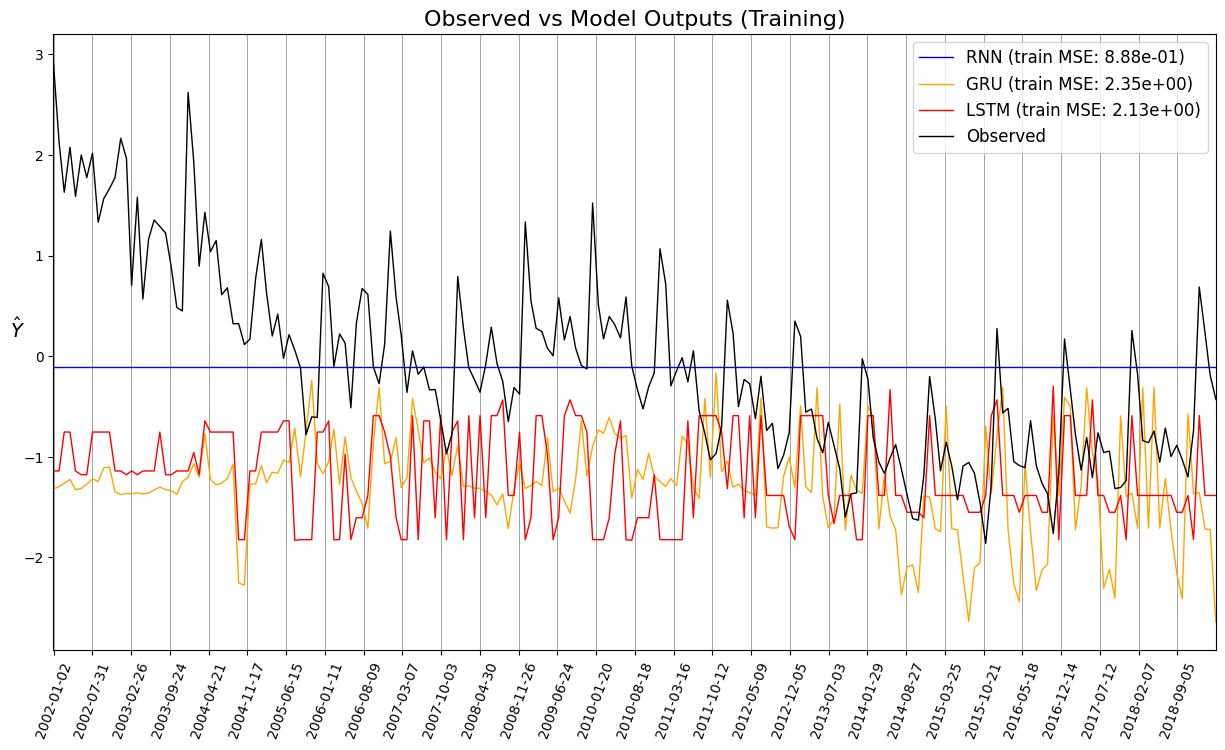

In [30]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params2[key]['pred_train'][l:u:ds]
    label = params2[key]['label'] + ' (train MSE: %.2e)' % params2[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

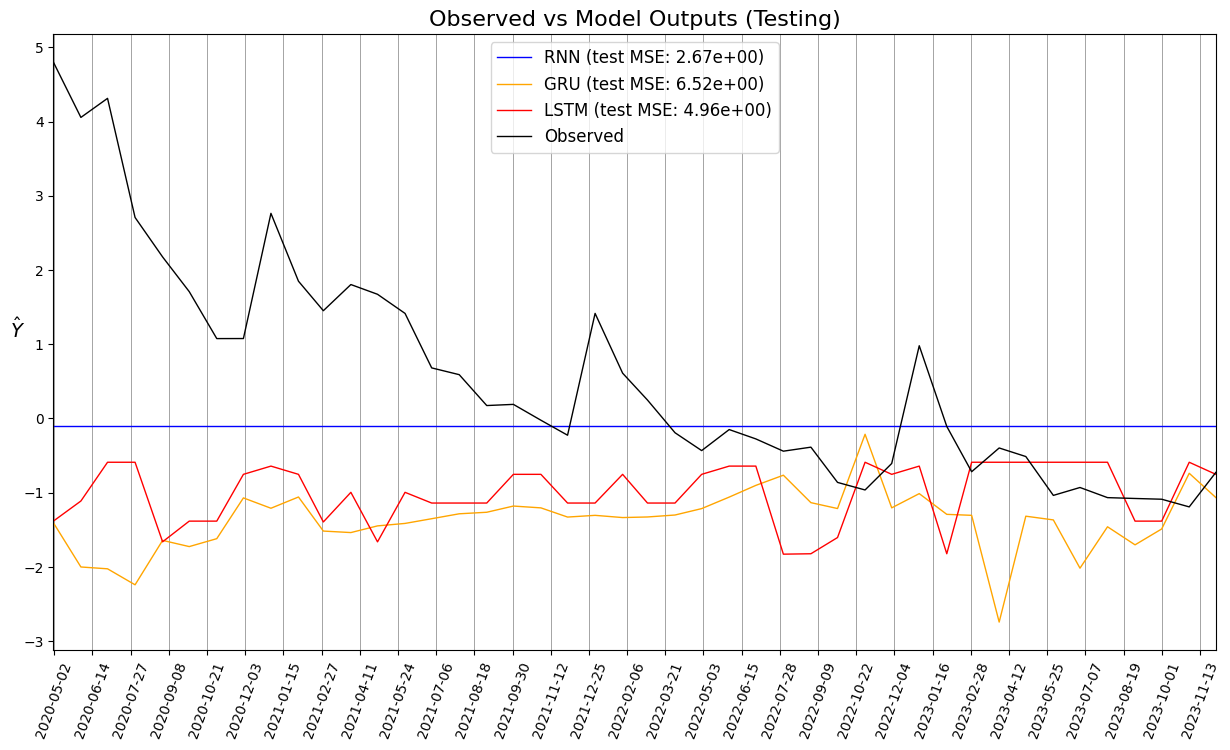

In [31]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params2[key]['pred_test'][l:u:ds]
    label = params2[key]['label'] + ' (test MSE: %.2e)' % params2[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

# MSE de ambas redes

## Redes sin covariables de estacionalidad

In [32]:
for key in params.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 2.970641783397666
El MSE de la red gru en el conjunto de prueba es 5.305906568978424
El MSE de la red lstm en el conjunto de prueba es 5.96381683289774


## Redes con covariables de estacionalidad

In [33]:
for key in params2.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params2[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 2.674250715964838
El MSE de la red gru en el conjunto de prueba es 6.520646061488063
El MSE de la red lstm en el conjunto de prueba es 4.959064866264518


In [35]:
params2['rnn']['pred_test']

array([[-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597],
       [-0.10710597]], dtype=float32)